<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/code/01RAD_Ex09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01RAD Exercise 09

* Robust Regression - How to deal with Outliers and Leverages
* Very fast intro of Robust regression - M, MM, LTS, LWS


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import seaborn as sns

import statsmodels.api as sm



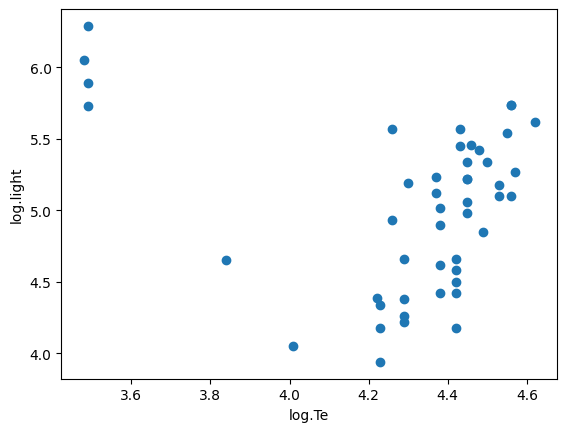

In [2]:
# Load the dataset
dta = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data

plt.scatter(dta['log.Te'], dta['log.light'])
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.show()


In [3]:
# Define the predictor and response variables
X = sm.add_constant(dta['log.Te'])  # Adding a constant for the intercept
y = dta['log.light']

# Fit the OLS model
OLS_stars = sm.OLS(y, X).fit()

print(OLS_stars.summary())

                            OLS Regression Results                            
Dep. Variable:              log.light   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.085
Date:                Tue, 03 Dec 2024   Prob (F-statistic):              0.156
Time:                        07:43:44   Log-Likelihood:                -38.804
No. Observations:                  47   AIC:                             81.61
Df Residuals:                      45   BIC:                             85.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7935      1.237      5.494      0.0

In [4]:
def summarize_influence_measures_with_data(model, data):
    """
    Summarize influence measures, flag outliers, and include original data columns.

    :param model: Fitted regression model object from statsmodels.
    :param data: DataFrame used to fit the regression model.
    :return: DataFrame summarizing influence measures, flagged outliers, and original data.
    """
    influence = model.get_influence()

    # Extract measures
    leverage = influence.hat_matrix_diag
    cooks_distance = influence.cooks_distance[0]
    dffits = influence.dffits[0]
    dfbetas = influence.dfbetas
    cov_ratios = influence.cov_ratio

    # Number of observations and predictors
    n = int(model.nobs)
    p = int(model.df_model) + 1  # Add 1 to include the intercept

    # Rule of Thumb thresholds
    leverage_threshold = 2 * (p) / n
    cooks_distance_threshold = 4 / n
    dffits_threshold = 2 * np.sqrt((p) / n)
    dfbetas_threshold = 2 / np.sqrt(n)

    # Summarize outliers based on thresholds
    flagged = {
        'High Leverage': leverage > leverage_threshold,
        'High Cook\'s Distance': cooks_distance > cooks_distance_threshold,
        'High DFFITS': np.abs(dffits) > dffits_threshold,
    }

    # Flag observations with high DFBETAS for any predictor
    for j in range(dfbetas.shape[1]):
        flagged[f'High DFBETAS (Predictor {j})'] = np.abs(dfbetas[:, j]) > dfbetas_threshold

    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Leverage': leverage,
        'Cook\'s Distance': cooks_distance,
        'DFFITS': dffits,
        'Covariance Ratio': cov_ratios
    })

    # Add flags for rule-of-thumb violations
    for key, flag in flagged.items():
        summary_df[key] = flag

    # Combine summary DataFrame with original data
    summary_with_data = pd.concat([data.reset_index(drop=True), summary_df], axis=1)

    # Select rows where any flag is True
    flag_columns = [col for col in summary_df.columns if 'High' in col]
    flagged_observations = summary_with_data.loc[summary_df[flag_columns].any(axis=1)]

    return summary_with_data, flagged_observations


In [5]:
# Apply the function
all_observations_with_im, flagged_observations = summarize_influence_measures_with_data(OLS_stars, dta)

# Display the flagged observations
flagged_observations

,log.Te,log.light,Leverage,Cook's Distance,DFFITS,Covariance Ratio,High Leverage,High Cook's Distance,High DFFITS,High DFBETAS (Predictor 0),High DFBETAS (Predictor 1)
10,3.49,5.73,0.194103,0.067314,0.365093,1.265854,True,False,False,True,True
13,4.01,4.05,0.044409,0.089975,-0.438769,0.914313,False,True,True,True,True
19,3.49,5.89,0.194103,0.136155,0.522609,1.233499,True,True,True,True,True
29,3.48,6.05,0.198344,0.233691,0.690666,1.197519,True,True,True,True,True
33,3.49,6.29,0.194103,0.413249,0.935330,1.107499,True,True,True,True,True


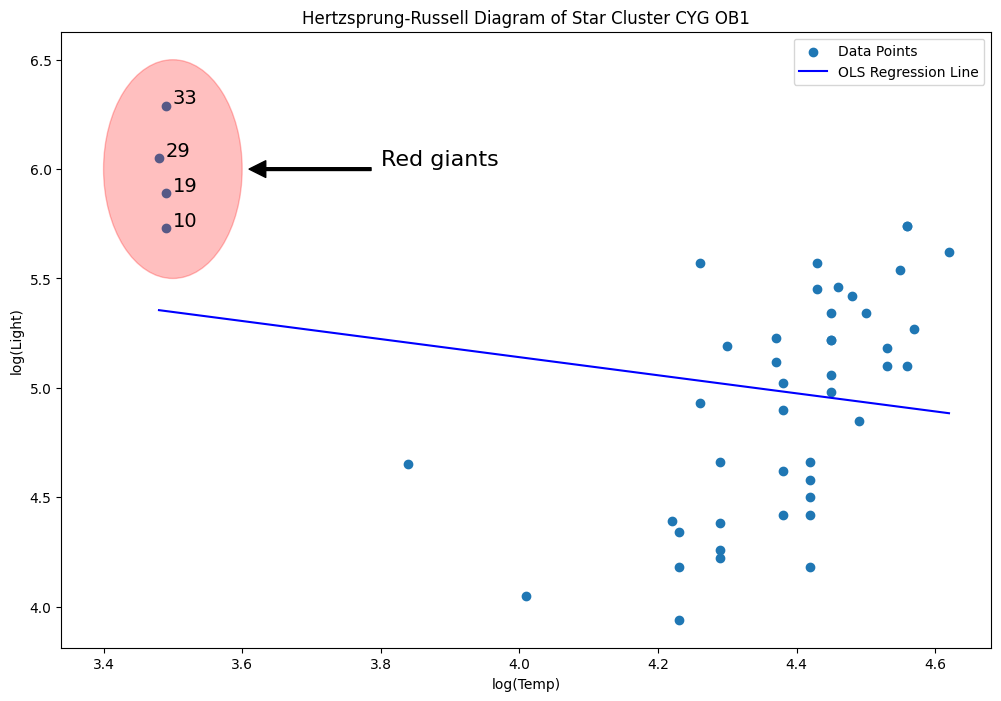

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    xlabel="log(Temp)",
    ylabel="log(Light)",
    title="Hertzsprung-Russell Diagram of Star Cluster CYG OB1",
)
ax.scatter(*dta.values.T, label='Data Points')

# Highlight outliers
e = Ellipse((3.5, 6), 0.2, 1, alpha=0.25, color="r")
ax.add_patch(e)
ax.annotate(
    "Red giants",
    xy=(3.6, 6),
    xytext=(3.8, 6),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
    horizontalalignment="left",
    verticalalignment="bottom",
    clip_on=True,  # Clip to the axes bounding box
    fontsize=16,
)

# Annotate observations with their index
for i, row in dta.loc[dta["log.Te"] < 3.8].iterrows():
    ax.annotate(i, row, row + 0.01, fontsize=14)

# Add the regression line from the OLS_stars model
# Generate x-values over the range of log.Te
x_vals = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 100)
X_plot = sm.add_constant(x_vals)  # Add intercept term

# Predict y-values using the OLS model
y_vals = OLS_stars.predict(X_plot)

# Plot the regression line
ax.plot(x_vals, y_vals, color='blue', label='OLS Regression Line')

# Add legend
ax.legend()

# Show the plot
plt.show()


https://github.com/jseabold/statsmodels-tutorial/blob/master/robust_models.ipynb

https://github.com/statsmodels/statsmodels/blob/main/examples/notebooks/robust_models_0.ipynb

In [7]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(OLS_stars)
summary_influence = influence.summary_frame()

In [8]:
summary_influence.head()

,dfb_const,dfb_log.Te,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.008988,0.013249,0.002145,0.434638,0.022202,0.065493,0.430686,0.064898
1,-0.181126,0.196636,0.043661,1.500387,0.037341,0.295502,1.522185,0.299795
2,-0.006446,0.004667,0.000380,-0.184082,0.021919,-0.027557,-0.182093,-0.027260
3,-0.181126,0.196636,0.043661,1.500387,0.037341,0.295502,1.522185,0.299795
4,0.004598,-0.001578,0.001053,0.311035,0.021302,0.045888,0.307890,0.045424


In [9]:
# Number of observations and predictors
n = int(OLS_stars.nobs)
p = int(OLS_stars.df_model) + 1  # Include intercept

# Define thresholds
leverage_threshold = 2 * p / n
cooks_d_threshold = 4 / n
dffits_threshold = 2 * np.sqrt(p / n)
dfbetas_threshold = 2 / np.sqrt(n)


In [10]:
# Create a copy to avoid modifying the original DataFrame
influence_df = summary_influence.copy()

# Calculate flags for each measure
influence_df['High Leverage'] = influence_df['hat_diag'] > leverage_threshold
influence_df['High Cook\'s Distance'] = influence_df['cooks_d'] > cooks_d_threshold
influence_df['High DFFITS'] = np.abs(influence_df['dffits']) > dffits_threshold

# For DFBETAS, since there might be multiple predictors, check any of them
dfbetas_cols = [col for col in influence_df.columns if 'dfb_' in col]
influence_df['High DFBETAS'] = (np.abs(influence_df[dfbetas_cols]) > dfbetas_threshold).any(axis=1)

# Combine all flags into one
influence_df['Influential'] = (
    influence_df['High Leverage'] |
    influence_df['High Cook\'s Distance'] |
    influence_df['High DFFITS'] |
    influence_df['High DFBETAS']
)


In [11]:
# Get the indices of influential observations
influential_obs = influence_df[influence_df['Influential']]

# Display influential observations
influential_obs


,dfb_const,dfb_log.Te,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits,High Leverage,High Cook's Distance,High DFFITS,High DFBETAS,Influential
10,0.351789,-0.344502,0.067314,0.747639,0.194103,0.366918,0.743920,0.365093,True,False,False,True,True
13,-0.336199,0.316673,0.089975,-1.967779,0.044409,-0.424206,-2.035329,-0.438769,False,True,True,True,True
19,0.503564,-0.493135,0.136155,1.063296,0.194103,0.521833,1.064878,0.522609,True,True,True,True,True
29,0.666189,-0.652571,0.233691,1.374420,0.198344,0.683653,1.388520,0.690666,True,True,True,True,True
33,0.901246,-0.882580,0.413249,1.852438,0.194103,0.909119,1.905847,0.935330,True,True,True,True,True


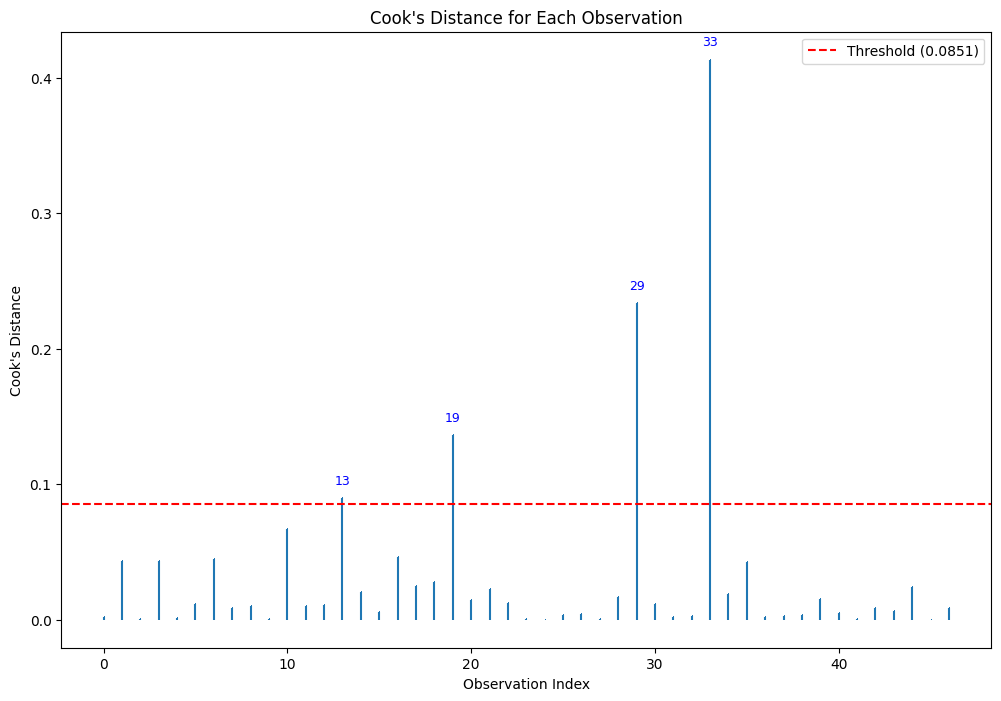

In [13]:
# Identify observations exceeding the threshold
cooks_d = summary_influence['cooks_d']
influential_obs = cooks_d > cooks_d_threshold
influential_indices = summary_influence[influential_obs].index

# Create the stem plot of Cook's Distance
plt.figure(figsize=(12, 8))
markerline, stemlines, baseline = plt.stem(
    summary_influence.index, cooks_d, markerfmt=",", basefmt=" "
)
plt.axhline(y=cooks_d_threshold, color='red', linestyle='--', label=f'Threshold ({cooks_d_threshold:.4f})')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.legend()

# Annotate influential observations
for idx in influential_indices:
    plt.annotate(
        str(idx),
        (idx, cooks_d[idx]),
        textcoords="offset points",
        xytext=(0, 10),  # Offset label above the point
        ha='center',
        fontsize=9,
        color='blue'
    )

plt.show()


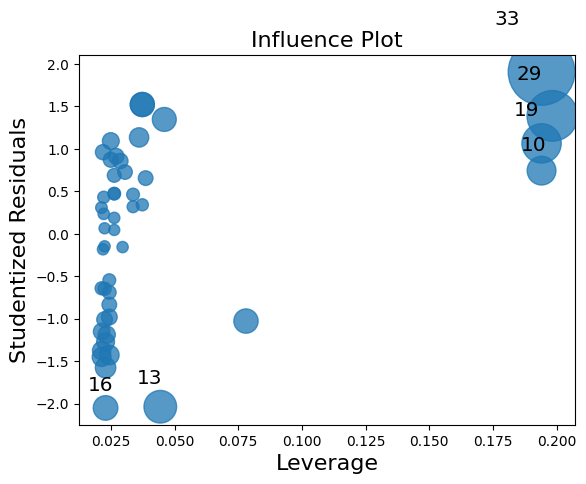

In [14]:
from statsmodels.graphics.regressionplots import influence_plot

influence_plot(OLS_stars, criterion="cooks")
plt.show()

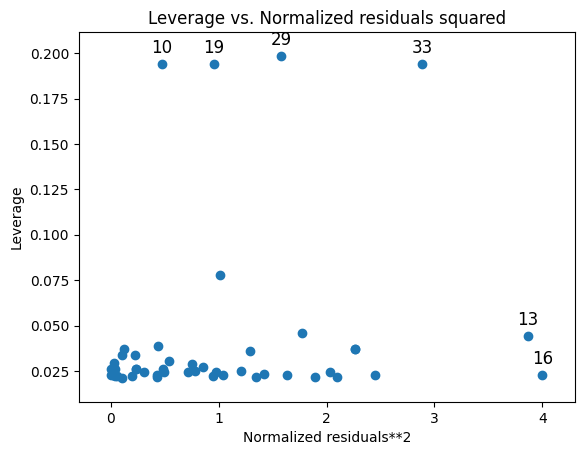

In [15]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plot_leverage_resid2(OLS_stars)
plt.show()

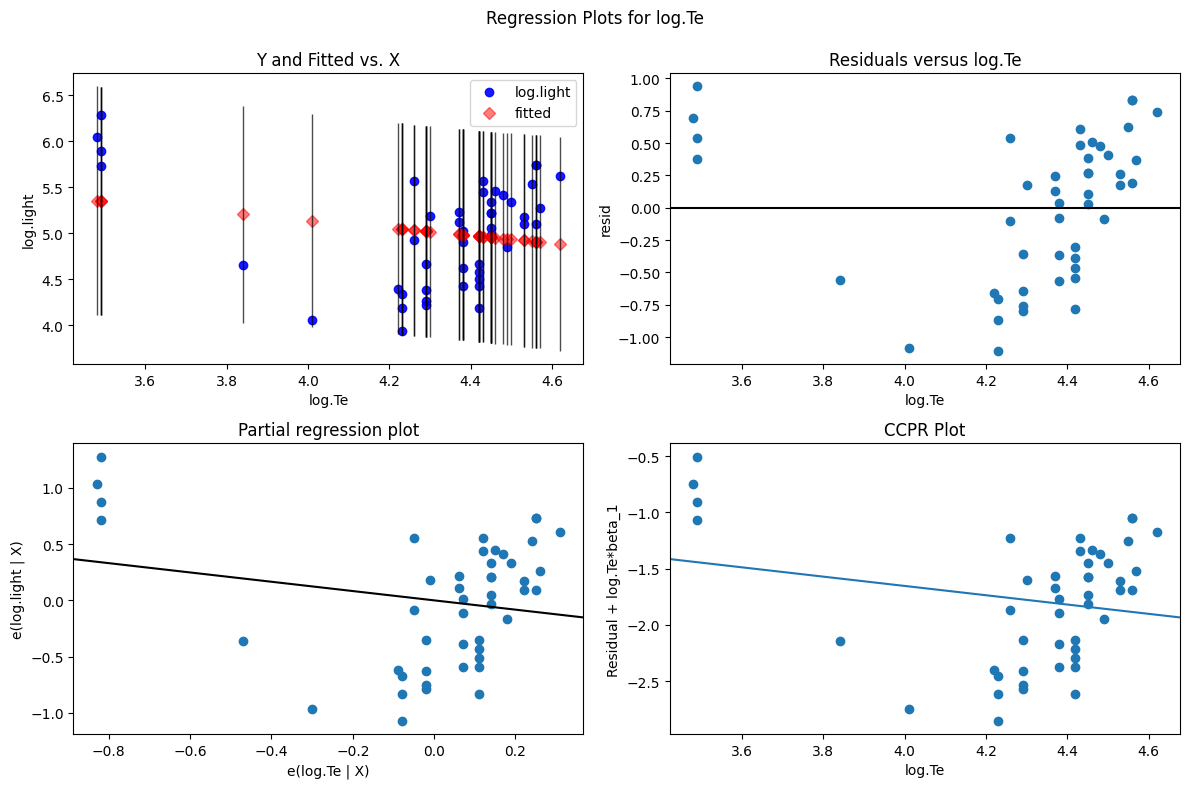

In [16]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(OLS_stars, 'log.Te', fig=fig)
plt.show()

## Robust Regression

In [17]:
# Robust regression using statsmodels' RLM

# Huber's T
huber_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.HuberT())
M_huber_stars = huber_model.fit()

# Hampel
hampel_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.Hampel())
M_hampel_stars = hampel_model.fit()

# Bisquare (Tukey's biweight)
bisquare_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.TukeyBiweight())
M_bisquare_stars = bisquare_model.fit()

# For MM estimators, statsmodels currently does not have a direct equivalent to R's rlm method='MM'

rlm_TrimmedMean = sm.RLM(dta['log.light'], X, sm.robust.norms.TrimmedMean(0.5))
M_TrimmedMean_stars = rlm_TrimmedMean.fit()

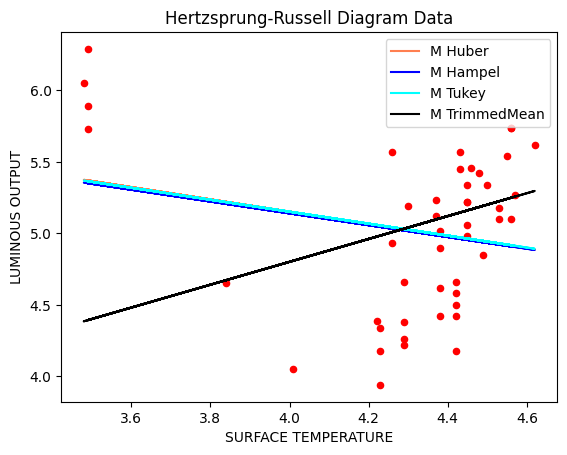

In [18]:
# Plotting the Hertzsprung-Russell Diagram Data with regression lines
plt.scatter(dta['log.Te'], dta['log.light'], color='red', s=20)
plt.xlabel('SURFACE TEMPERATURE')
plt.ylabel('LUMINOUS OUTPUT')
plt.title('Hertzsprung-Russell Diagram Data')

# Adding regression lines
plt.plot(dta['log.Te'], M_huber_stars.fittedvalues, color='coral', label='M Huber')
plt.plot(dta['log.Te'], M_hampel_stars.fittedvalues, color='blue', label='M Hampel')
plt.plot(dta['log.Te'], M_bisquare_stars.fittedvalues, color='cyan', label='M Tukey')
plt.plot(dta['log.Te'], M_TrimmedMean_stars.fittedvalues, color='black', label='M TrimmedMean')


plt.legend()
plt.show()


In [19]:
!pip install rpy2
%load_ext rpy2.ipython

In [20]:
%%R
install.packages('robustbase')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpOUBKZn/downloaded_packages’



In [30]:
%%R
library(robustbase)
data(starsCYG)
? starsCYG

File: /tmp/RtmpOUBKZn/Rtxt44dc30dae11c
starsCYG              package:robustbase               R Documentation



_H_e_r_t_z_s_p_r_u_n_g-_R_u_s_s_e_l_l _D_i_a_g_r_a_m _D_a_t_a _o_f _S_t_a_r _C_l_u_s_t_e_r _C_Y_G _O_B_1



_D_e_s_c_r_i_p_t_i_o_n:



     Data for the Hertzsprung-Russell Diagram of the Star Cluster CYG

     OB1, which contains 47 stars in the direction of Cygnus, from

     C.Doom.  The first variable is the logarithm of the effective

     temperature at the surface of the star (Te) and the second one is

     the logarithm of its light intencity (L/L_0).



     In the Hertzsprung-Russell diagram, which is the scatterplot of

     these data points, where the log temperature is plotted from left

     to right, two groups of points are seen:

     the majority which tend to follow a steep band and four stars in

     the upper corner.  In the astronomy the 43 stars are said to lie

     on the main sequence and

In [34]:
%%R
library(robustbase)
data(starsCYG)
head(starsCYG)

  log.Te log.light
1   4.37      5.23
2   4.56      5.74
3   4.26      4.93
4   4.56      5.74
5   4.30      5.19
6   4.46      5.46


https://cran.r-project.org/web/packages/robustbase/vignettes/psi_functions.pdf

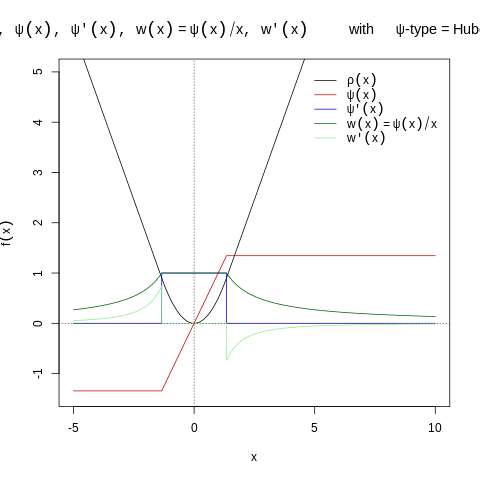

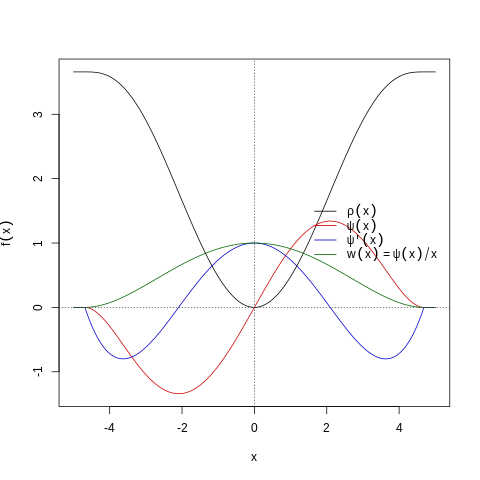

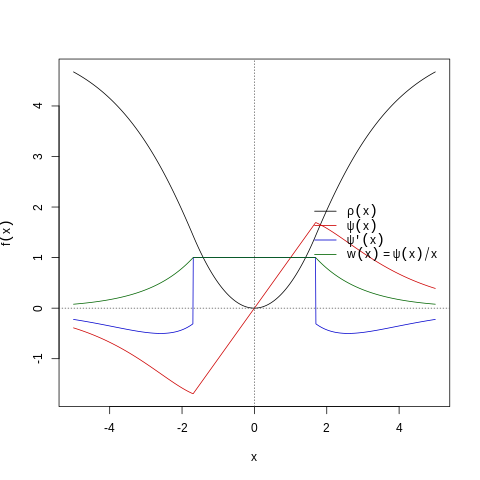

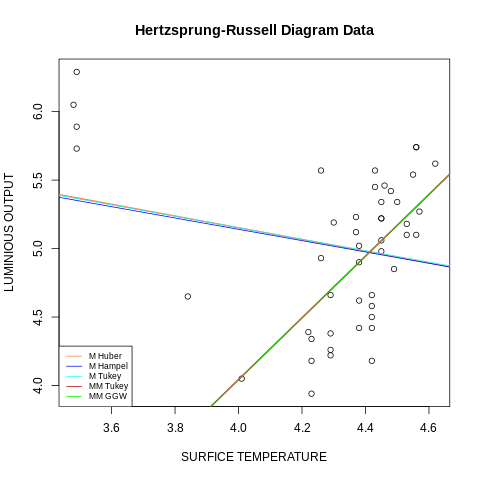

In [36]:
%%R
library(MASS)
# Robust regression by M-estimator
# rlm(formula, data,..., method = c("M","MM"))
# M estimate with diferent types of weight functions psi (derivative of rho)
# MM estimate - S estimate + M estimate

# Definitions of Psi-Functions Available in Robustbase
# See enclosed pdf file

# Huber family of functions using tuning parameter k = 1.345.
names(.Mpsi.tuning.defaults)
plot(huberPsi, ylim=c(-1.4, 5), leg.loc="topright",cex=0.8)

# Bisquare family functions using tuning parameter k = 4.685
x = seq(-5,5,by=0.01)
source(system.file("xtraR/plot-psiFun.R", package = "robustbase", mustWork=TRUE))
p.psiFun( x, "biweight", par = 4.685)

# GGW (Generalized Gauss-Weight function )family of functions
# using tuning parameters a = 1.387, b = 1.5 and c = 1.063.
p.psiFun(x, "GGW", par = c(-.5, 1, .95, NA))

data(starsCYG)
attach(starsCYG)

# rlm from MASS
# Summary plot for starsCYG
M_huber_stars    <- rlm(log.light ~ log.Te, method="M", psi = psi.huber)    # Huber
M_hampel_stars   <- rlm(log.light ~ log.Te, method="M", psi = psi.hampel)   # Hampel
M_bisquare_stars <- rlm(log.light ~ log.Te, method="M", psi = psi.bisquare) # Tukey
MM_bisquare_stars<- rlm(log.light ~ log.Te, method="MM",psi = psi.bisquare) # Tukey
MM_ggw_stars     <- rlm(log.light ~ log.Te, method="MM",psi = psi.ggw)      # GGW
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(M_huber_stars, col="coral",lwd=1.8)
abline(M_hampel_stars, col="blue")
abline(M_bisquare_stars, col="cyan")
abline(MM_bisquare_stars, col="firebrick", lwd = 2)
abline(MM_ggw_stars, col="green")
legend("bottomleft",cex=0.7,legend = c("M Huber","M Hampel","M Tukey","MM Tukey","MM GGW"),
       lty = c(1,1,1,1,1),col = c("coral","blue","cyan","firebrick","green"))




In [37]:
%%R
coef(summary(MM_ggw_stars))


                Value Std. Error   t value
(Intercept) -4.970248  0.9627489 -5.162559
log.Te       2.253355  0.2228796 10.110193


In [38]:
%%R
# alternative to MM from rlm is lmrob from robustbase package
# lmrob computes fast MM-type estimator
# ? mlrob - MM-type Estimators for Linear Regression
# ? nlrob - Robust Fitting of Nonlinear Regression Models

MM_stars2 <- lmrob(log.light ~ log.Te, init = "S")
MM_stars2$coefficients
summary(MM_stars2)
coef(summary(MM_stars2))

             Estimate Std. Error   t value   Pr(>|t|)
(Intercept) -4.969388  3.4100348 -1.457284 0.15198154
log.Te       2.253161  0.7690606  2.929758 0.00531065


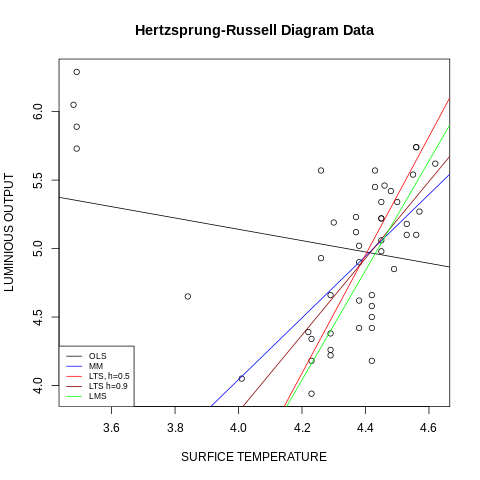

In [39]:
%%R
# Robust regression by LMS-estimator
LMS_stars  <- lmsreg(log.light ~ log.Te)
LMS_stars


# Robust regression by LTS-estimator
# two possibilities - ltsreg from MASS (lqs(formula, data, ..., method = c("lts")))
#                   - ltsReg from robustbase
?ltsreg
?ltsReg

LTS_stars  <- ltsreg(log.light ~ log.Te)

LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.9)
# when stop the algorithm?
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="best")
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="best")
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="exact")



# Summary plot for starsCYG
OLS_stars  <- lm(log.light ~ log.Te)
MM_stars   <- rlm(log.light ~ log.Te,method="MM")
LTS_stars  <- ltsreg(log.light ~ log.Te)
LTS2_stars <- ltsReg(log.light ~ log.Te, alpha=0.9)
LMS_stars  <- lmsreg(log.light ~ log.Te)
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(OLS_stars, col="black")

abline(MM_stars, col="blue")
abline(LTS_stars, col="red")
abline(LTS2_stars, col="darkred")
abline(LMS_stars, col="green")
legend("bottomleft",cex=0.7,legend = c("OLS","MM","LTS, h=0.5","LTS h=0.9","LMS"),
         lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))

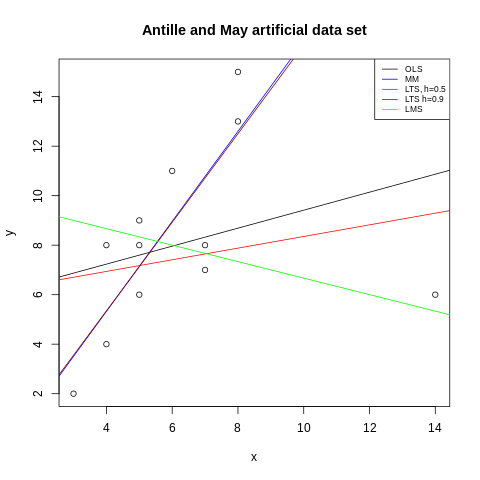

In [40]:
%%R
#GM-estimation
# MASS: rlm() with method=''M'' (Huber, Tukey, Hampel)
#               Choice for the scale estimator: MAD, Huber Proposal 2
#S-estimation
# robust: lmRob with estim=''Initial''
# robustbase: lmrob.S
#MM-estimation
# MASS: rlm() with method=''MM''
# robust: lmRob (with estim='''Final'', default)
# robustbase: lmrob()


# Problems with general position
data(exAM)
? exAM
summary(exAM)

#Because the points are not in general position, both LMS and LTS typically fail
summary(lm1   <- lm(y ~ x, data=exAM))
summary(rlm0  <- rlm(y ~ x, data=exAM,method="MM"))
summary(rlm1  <- ltsReg(y ~ x, data=exAM))
summary(rlm1b <- ltsReg(y ~ x, alpha = 0.9,data=exAM))
summary(rlm2  <- lmsreg(y ~ x, data=exAM))


plot(exAM,main="Antille and May artificial data set")
abline(lm1, col="black")
abline(rlm0, col="blue")
abline(rlm1, col="red")
abline(rlm1b, col="darkred")
abline(rlm2, col="green")
legend("topright",cex=0.7,legend = c("OLS","MM","LTS, h=0.5","LTS h=0.9","LMS"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


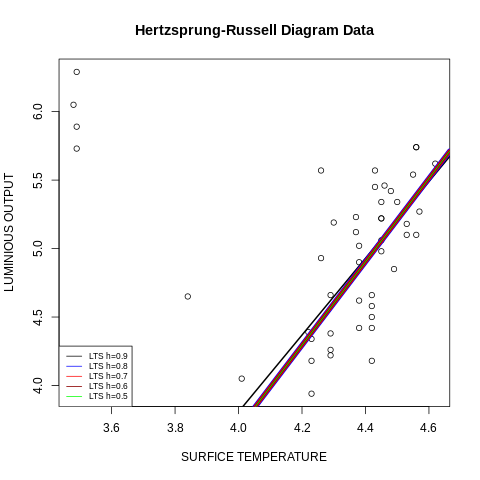

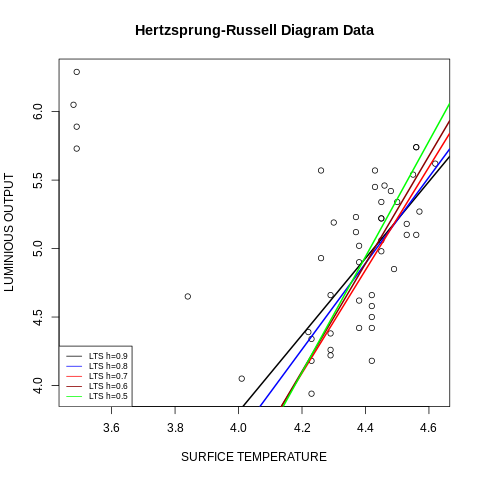

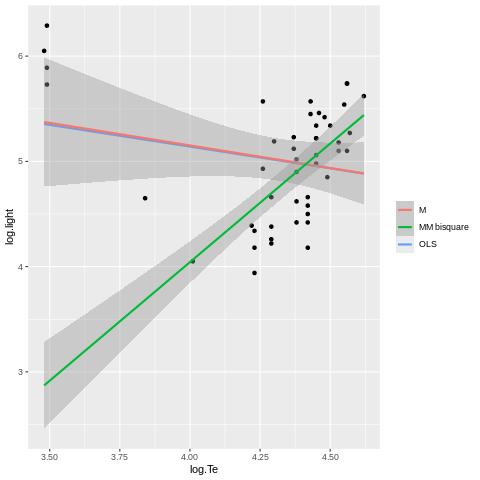

In [41]:
%%R
library(tidyverse)
# THE PROBLEM IS HOW LARGE h (alpha) WE SHOULD SELECT FOR LTS
# for example in Stars data - nearly now change
# How trimmed parameter h (alpha) change the estimation?
LTS_stars09 <- ltsReg(log.light ~ log.Te, alpha=0.9)
LTS_stars08 <- ltsReg(log.light ~ log.Te, alpha=0.8,nsamp="exact",adjust=F,mcd = F)
LTS_stars07 <- ltsReg(log.light ~ log.Te, alpha=0.7)
LTS_stars06 <- ltsReg(log.light ~ log.Te, alpha=0.6)
LTS_stars05 <- ltsReg(log.light ~ log.Te, alpha=0.5,nsamp="exact",adjust=F,mcd = F)
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(LTS_stars09, col="black", lwd = 2)
abline(LTS_stars08, col="blue", lwd = 7)
abline(LTS_stars07, col="red", lwd = 5)
abline(LTS_stars06, col="darkred", lwd = 3)
abline(LTS_stars05, col="green", lwd = 1)
legend("bottomleft",cex=0.7,legend = c("LTS h=0.9","LTS h=0.8","LTS h=0.7","LTS h=0.6","LTS h=0.5"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))

# Ups, why does it have same number of DF?
summary(LTS_stars05)
summary(LTS_stars08)

# Let's check outputs
LTS_stars05$quan
LTS_stars08$quan

LTS_stars05$crit
LTS_stars08$crit

# But coefficents are same :(
LTS_stars05$coefficients
LTS_stars08$coefficients

# h points with smallest resids
LTS_stars05$best
LTS_stars08$best

# Apply ordinary LS to h best (selected) points
LTS_stars05OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars05$best,])
LTS_stars06OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars06$best,])
LTS_stars07OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars07$best,])
LTS_stars08OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars08$best,])
LTS_stars09OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars09$best,])

# commpare
summary(LTS_stars05OLS)
summary(LTS_stars08OLS)

plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(LTS_stars09OLS, col="black", lwd = 2)
abline(LTS_stars08OLS, col="blue", lwd = 2)
abline(LTS_stars07OLS, col="red", lwd = 2)
abline(LTS_stars06OLS, col="darkred", lwd = 2)
abline(LTS_stars05OLS, col="green", lwd = 2)
legend("bottomleft",cex=0.7,legend = c("LTS h=0.9","LTS h=0.8","LTS h=0.7","LTS h=0.6","LTS h=0.5"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))




ggplot(data=starsCYG, aes(log.Te, log.light)) +                    # use starsCYGdata frame
  geom_point() +
  geom_smooth(method="lm", aes(colour="OLS"), se=F) +
  geom_smooth(method="rlm", aes(colour="M"), se=T) +
  stat_smooth(method=function(formula,data,weights=weight) rlm(formula,
                                                               data,
                                                               weights=weight,
                                                               method="MM",
                                                               psi=psi.bisquare),
              fullrange=TRUE,aes(colour="MM bisquare"))+
  labs(colour=NULL)


In [43]:
%%R
LWS <- function(y, x, w, niter){

    n <- nrow(x)
    p <- ncol(x)

   rWr_LWS=Inf;
   # iterations = rep(0,times=n);
   # Outer Cycle
   for(i in 1:niter) {
   # Performing one iteration in the outer cycle
   #    [b_OneIter,S_OneIter,rWr_OneIter,perm_OneIter,iterations_OneIter]=OneIter(X,Z,Y,w);
   OneIter = LWS_OneIter(y,x,w)

    if (rWr_LWS > OneIter$rWr){
    b_LWS      =  OneIter$b
    rWr_LWS    =  OneIter$rWr
    perm_LWS   =  OneIter$perm
    }
   }

    result <- list(beta=b_LWS, resid = rWr_LWS, rank=perm_LWS)
    return(result)
}

LWS_OneIter = function(Y, X, w){

    n <- nrow(X)
    p <- ncol(X)
    W <- diag(w);
    tau         <- 0.00001;
    rWr_OneIter <- Inf;
    b_OneIter   <- matrix( rep(0,times=p),p,1);

    # Select the initial values
    index  = sample(n)
    SX     = X[(index[1:p+2]),]
    SY     = Y[index[1:p+2]]
    while(kappa(SX) > 1e9 ){
        index  = sample(n)
        SX     = X[(index[1:(p+5)]),]
        SY     = Y[index[1:(p+5)]]
    }
    #print(kappa(SX))
    b      = OLS_qr(SY,SX)

    # Run the inner cycle
    while (sum(abs(b_OneIter - b) < tau) != p){
          #  rWr_OneIter > rWr && sum(abs(b_OneIter - b) < tau) ~= p;
          b_OneIter     = b

          r      = (Y-X%*%b)^2
          rI     = order(r)
          sX     = X[rI,]
          sY     = Y[rI,]

          swX    = (sqrt(w)*sX)[which(w != 0),]
          swY    = (sqrt(w)*sY)[which(w != 0)]
          b      = OLS_qr(swY,swX)
    }
    b_OneIter      = b
    r_OneIter      = (Y-X%*%b_OneIter)^2
    perm_OneIter   = order(r_OneIter)
    rWr_OneIter    = (r_OneIter[perm_OneIter]^2)%*%w
    # S      = t((sY-sX%*%b)^2)%*%w
    result_OneIter <- list(b=b_OneIter, rWr = rWr_OneIter, perm=perm_OneIter)
    return(result_OneIter)
}


OLS_qr = function(y, x, tol=1.e-07 ){
    qr_x <- qr(x, tol=tol, LAPACK=TRUE)
    b<-qr.coef(qr_x, y)
    return(b)
}

OLS_lm <- function (y, x){
    b<-coef(lm(y ~ x - 1))
    return(b)
}

OLS_def <- function (y, x) {
    b <- as.vector((solve(t(x)%*%x))%*%(t(x)%*%y))
    return(b)
}


Weights1 <- function(n){
    # Generating weights
    # h      - number of trimmed observations (observations with zero weights)
    # g      - number of observations with weights equal to 1
    # h-g-1  - number of observations with rapidly decreasing weights
h <- ceiling(0.9*n)
g <- ceiling(0.8*n)
w <- rep(0,times=n)
w[1:g] <- 1
w[g:h] <- seq(1,0,length=h-g+1)
return(w)
}


In [47]:
%%R
LWS <- function(y, x, w, niter){
    n <- nrow(x)
    p <- ncol(x)

   rWr_LWS=Inf;
   # iterations = rep(0,times=n);
   # Outer Cycle
   for(i in 1:niter) {
   # Performing one iteration in the outer cycle
   #    [b_OneIter,S_OneIter,rWr_OneIter,perm_OneIter,iterations_OneIter]=OneIter(X,Z,Y,w);
   OneIter = LWS_OneIter(y,x,w)

    if (rWr_LWS > OneIter$rWr){
    b_LWS      =  OneIter$b
    rWr_LWS    =  OneIter$rWr
    perm_LWS   =  OneIter$perm
    }
   }

    result <- list(beta=b_LWS, resid = rWr_LWS, rank=perm_LWS)
    return(result)
}

LWS_OneIter = function(Y, X, w){

    n <- nrow(X)
    p <- ncol(X)
    W <- diag(w);
    tau         <- 0.00001;
    rWr_OneIter <- Inf;
    b_OneIter   <- matrix( rep(0,times=p),p,1);

    # Select the initial values
    index  = sample(n)
    SX     = X[(index[1:p+2]),]
    SY     = Y[index[1:p+2]]
    while(kappa(SX) > 1e9 ){
        index  = sample(n)
        SX     = X[(index[1:(p+5)]),]
        SY     = Y[index[1:(p+5)]]
    }
    #print(kappa(SX))
    b      = OLS_qr(SY,SX)

    # Run the inner cycle
    while (sum(abs(b_OneIter - b) < tau) != p){
          #  rWr_OneIter > rWr && sum(abs(b_OneIter - b) < tau) ~= p;
          b_OneIter     = b

          r      = (Y-X%*%b)^2
          rI     = order(r)
          sX     = X[rI,]
          sY     = Y[rI,]

          swX    = (sqrt(w)*sX)[which(w != 0),]
          swY    = (sqrt(w)*sY)[which(w != 0)]
          b      = OLS_qr(swY,swX)
    }
    b_OneIter      = b
    r_OneIter      = (Y-X%*%b_OneIter)^2
    perm_OneIter   = order(r_OneIter)
    rWr_OneIter    = (r_OneIter[perm_OneIter]^2)%*%w
    # S      = t((sY-sX%*%b)^2)%*%w
    result_OneIter <- list(b=b_OneIter, rWr = rWr_OneIter, perm=perm_OneIter)
    return(result_OneIter)
}


OLS_qr = function(y, x, tol=1.e-07 ){
    qr_x <- qr(x, tol=tol, LAPACK=TRUE)
    b<-qr.coef(qr_x, y)
    return(b)
}

OLS_lm <- function (y, x){
    b<-coef(lm(y ~ x - 1))
    return(b)
}

OLS_def <- function (y, x) {
    b <- as.vector((solve(t(x)%*%x))%*%(t(x)%*%y))
    return(b)
}


Weights1 <- function(n){
    # Generating weights
    # h      - number of trimmed observations (observations with zero weights)
    # g      - number of observations with weights equal to 1
    # h-g-1  - number of observations with rapidly decreasing weights
h <- ceiling(0.9*n)
g <- ceiling(0.8*n)
w <- rep(0,times=n)
w[1:g] <- 1
w[g:h] <- seq(1,0,length=h-g+1)
return(w)
}



    log.light, log.Te



    log.light, log.Te




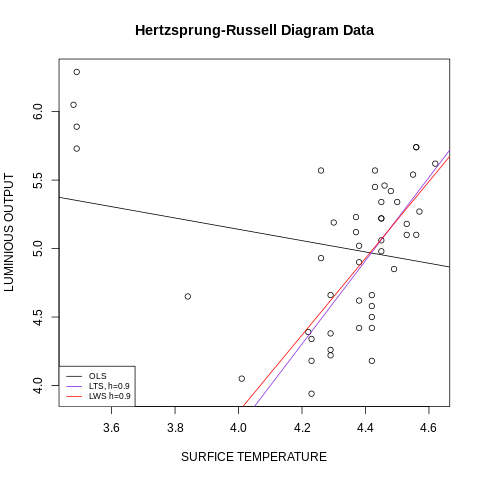

In [48]:
%%R
n=100
p=3
beta0 <- matrix(c(2,3,-4),p,1)

set.seed(123)
X1 <- rep(1,times=n)
X2 <- rnorm(n,10,2)
X3 <- rexp(n,1/5)
X  <- cbind(X1, X2, X3)
e  <- rnorm(n,0,1)
Y  <- X%*%beta0 + e

# Vytvorime 5% outlieru
Yoi    = sample(n)[1:ceiling(n/20)]
Y[Yoi] = 5*Y[Yoi]

# Vytvorime 5% Leverage pointu
Xoi     = sample(n)[1:ceiling(n/20)]
X[Xoi,2:p]  = 0.2*X[Xoi,2:p]



w = Weights1(n)
OLS_qr(Y,X)
LWS(Y,X,w,100)$beta
summary(ltsReg(Y ~ X2+X3, alpha=0.9))$coeff


#Use Hertzsprung-Russell Diagram Data of Star Cluster CYG OB1
? starsCYG
summary(starsCYG)
attach(starsCYG)

w_star       <- Weights1(nrow(starsCYG))
YY = as.matrix(log.light)
XX = cbind(rep(1,times=nrow(YY)), log.Te)
LWS_stars_lm <- LWS(YY, XX, w_star, 1000)
LTS_stars    <- ltsReg(log.light ~ log.Te, alpha=0.9)
OLS_stars    <- lm(log.light ~ log.Te)

plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(OLS_stars, col="black")
abline(LWS_stars_lm$beta, col="blueviolet")
abline(LTS_stars, col="red")
legend("bottomleft",cex=0.7,legend = c("OLS","LTS, h=0.9","LWS h=0.9"),
       lty = c(1,1,1),col = c("black","blueviolet","red"))



# Task 01: Regression Analysis Experimentation

### 1. Compare LWS with Other Methods
- Utilize the **Locally Weighted Scatterplot Smoothing (LWS)** method on the dataset from the previous lesson.
- Compare the results of LWS with other regression methods (e.g., OLS or LTS).
- Experiment by varying the input parameters of the LWS method to observe changes in performance and results.

### 2. Implement Custom Weight Function for LWS
- Create a function `Weights2` to generate weights for the LWS method:
  - For the first `g` observations, the weights should decrease linearly such that over the interval `(0, g)` the weight reduces by 0.1.
  - Over the interval `(g, h)`, the weights should decrease from 0.9 to 0.
  - For the remaining `(n-h)` observations, the weights should be zero (i.e., weights are null over `(h, n)`).
  - Parameters `g` and `h` should be inputs to this function.

### 3. Experiment: Consistency of Regression Parameter Estimation
- Conduct experiments to test the consistency of regression parameter estimates using LWS.
- Generate data for different numbers of observations: `50, 100, 200, 300, 400, 500`.
- Structure the design matrix `X` with the following columns:
  1. Intercept term (constant).
  2. Binomially distributed observations (`k=10`, `p=0.3`) shifted by +1.
  3. Normally distributed observations with `N(10, 2)`.
  4. Normally distributed observations with `N(20, 3)`.
  5. Exponentially distributed observations with a mean of 8.
- Use a regression coefficient vector: `beta0 = [2, 3, -2, 2, 3]`.

### 4. Evaluate and Visualize Results
- For each specified number of observations, generate 1000 datasets.
- Compute parameter estimates using **OLS**, **LWS**, and **LTS** methods.
- Calculate:
  - The empirical **median of the standard error (SE)** or the **mean squared error (MSE)** for each parameter estimate.
- Plot the dependence of the median (or eMSE) on the number of observations for all three methods.

### 5. Handle Outliers
- Repeat the experiment with:
  - **0%**, **5%**, and **10% outliers** in the dataset.
- Design outliers based on your assumptions or domain-specific logic.
